In [1]:
import os
import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask as rmask

In [2]:


# roi = r"C:\Users\Owner\Desktop\Desktop\12_Days_Geopython_Training\Day 12\shp\boundary.shp"
# composite_path = r"\Users\Owner\Desktop\Desktop\12_Days_Geopython_Training\Day 12\composite.tif"

# output_path = './output'

# os.makedirs(output_path, exist_ok = True)
# # composite_path = r"C:\Users\Owner\Desktop\Desktop\12_Days_Geopython_Training\Day 9\images\rasters\Band1.TIF"
# clipped_path = os.path.join(output_path, "clipped.tif")

# gdf = gpd.read_file(roi)
# print(gdf)

# with rio.open(composite_path) as src:
#     shapes = gdf.geometry

#     print(src.meta)
#     print(shapes)

#     cropped_image, cropped_image_transform = rmask(src, shapes, crop=True)

#     out_meta = src.meta.copy()

#     out_meta.update({
#         "height": cropped_image.shape[1],
#         "width": cropped_image.shape[2],
#         "transform": cropped_image_transform
#     })
    
#     # Save the cropped image
# with rio.open(clipped_path, 'w', **out_meta) as dst:
#     dst.write(cropped_image)

### Supervised Image Classification

In [3]:
import warnings

warnings.filterwarnings(action="ignore")

In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import keras
import matplotlib.pyplot as plt
from rasterio.plot import show as r_show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score
from tqdm import tqdm




### Source files and folders

In [5]:
training_shapefile_path = r".\shp\signature.shp"
rasters_path = r"C:\Users\Owner\Desktop\Desktop\12_Days_Geopython_Training\Day 11\images\cropped"

classified_path = r".\classified"
os.makedirs(classified_path, exist_ok=True)

training_shapefile = gpd.read_file(training_shapefile_path)




### Categorize Training Labels

In [6]:
training_shapefile
training_shapefile.drop(columns="id", inplace=True)
training_shapefile

,Name,geometry
0,Water,POINT (674629.17 719739.803)
1,Water,POINT (677243.573 720180.433)
2,Water,POINT (677566.701 717830.408)
3,Water,POINT (674599.795 717477.905)
4,Vegetation,POINT (680886.111 723029.838)
5,Vegetation,POINT (682619.254 715597.885)
6,Vegetation,POINT (672279.146 725497.364)
7,Vegetation,POINT (670634.128 716919.774)
8,Built-Up,POINT (670516.627 721502.322)
9,Built-Up,POINT (673042.904 714099.744)


In [7]:
keys = {
    "Water": 1,
    "Vegetation": 2,
    "Built-Up": 3
}


def categorize_labels(record):
    return keys[record]

print(categorize_labels("Vegetation"))

training_shapefile['LULC_Class'] = training_shapefile['Name'].apply(categorize_labels)
training_shapefile

2


,Name,geometry,LULC_Class
0,Water,POINT (674629.17 719739.803),1
1,Water,POINT (677243.573 720180.433),1
2,Water,POINT (677566.701 717830.408),1
3,Water,POINT (674599.795 717477.905),1
4,Vegetation,POINT (680886.111 723029.838),2
5,Vegetation,POINT (682619.254 715597.885),2
6,Vegetation,POINT (672279.146 725497.364),2
7,Vegetation,POINT (670634.128 716919.774),2
8,Built-Up,POINT (670516.627 721502.322),3
9,Built-Up,POINT (673042.904 714099.744),3


### Read the bands into a numpy array

In [8]:
images_nparray = []

images = [ item for item in os.listdir(rasters_path) if item.lower().endswith('.tif')]

for raster in images:
    path = os.path.join(rasters_path, raster)
    src = rio.open(path)
    band = src.read(1)
    images_nparray.append(band)

images_nparray


[array([[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ..., 8136, 8112,    0],
        [   0,    0,    0, ..., 8087, 8094,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16),
 array([[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ..., 8411, 8418,    0],
        [   0,    0,    0, ..., 8384, 8379,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16),
 array([[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ..., 9378, 9410,    0],
        [   0,    0,    0, ..., 9398, 9355,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=uint

# Extract band values into a column in the training shapefiles

In [9]:
number_of_training_samples = len(training_shapefile['Name'])

number_of_training_samples

# spectral data

spectral_data = []

for index in range(number_of_training_samples):

    # get the geographic coordinates of signatures
    UTM_x, UTM_y = training_shapefile['geometry'][index].x, training_shapefile['geometry'][index].y

    # Convert to pixel coordinates
    x,y = src.index(UTM_x, UTM_y)

    x,y = int(x), int(y)

    # Extract band values 
    band_value_at_xy = []

    for band in range(len(images)):
        try:
            i = images_nparray[band][y,x]
            band_value_at_xy.append(i)
        except IndexError:
            band_value_at_xy.append(np.nan)
    spectral_data.append(band_value_at_xy)

training_shapefile['spectral_data'] = spectral_data


training_shapefile

,Name,geometry,LULC_Class,spectral_data
0,Water,POINT (674629.17 719739.803),1,"[7253, 8058, 9958, 9383, 9548, 8835, 8410]"
1,Water,POINT (677243.573 720180.433),1,"[7219, 7957, 9632, 9119, 9215, 8535, 8162]"
2,Water,POINT (677566.701 717830.408),1,"[7038, 7825, 9639, 9120, 9326, 8635, 8237]"
3,Water,POINT (674599.795 717477.905),1,"[7735, 8375, 9975, 9438, 9716, 8818, 8388]"
4,Vegetation,POINT (680886.111 723029.838),2,"[nan, nan, nan, nan, nan, nan, nan]"
5,Vegetation,POINT (682619.254 715597.885),2,"[nan, nan, nan, nan, nan, nan, nan]"
6,Vegetation,POINT (672279.146 725497.364),2,"[9263, 9997, 11984, 12620, 16462, 17050, 15519]"
7,Vegetation,POINT (670634.128 716919.774),2,"[8800, 9768, 11510, 11414, 18952, 15253, 12648]"
8,Built-Up,POINT (670516.627 721502.322),3,"[14240, 15236, 16394, 17300, 22133, 16488, 12955]"
9,Built-Up,POINT (673042.904 714099.744),3,"[8085, 8412, 9448, 8947, 18132, 13358, 10065]"


### Create test and train split

In [10]:
train_indices, test_indices, train_data, test_data = [], [], [],[]

number_of_classes = 3

for i in range(1, number_of_classes + 1):
    data_class_i = training_shapefile[training_shapefile['LULC_Class'] == i]['spectral_data'].tolist()
    indices_class_i = training_shapefile[training_shapefile['LULC_Class'] == i].index.tolist()

    # print(data_class_i)
    # print(indices_class_i)

    train_data_list, test_data_list, train_index_list, test_index_list = train_test_split(
        data_class_i, indices_class_i, test_size=0.3, random_state=42
    )

    train_data.extend(train_data_list)
    test_data.extend(test_data_list)
    train_indices.extend(train_index_list)
    test_indices.extend(test_index_list)


# Convert data and labels into numpy array
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_indices)
print(test_indices)

train_labels = training_shapefile.loc[train_indices, 'LULC_Class'].values
test_labels = training_shapefile.loc[test_indices, 'LULC_Class'].values

# print(train_labels)

# Convert labels to categoricals
train_label_categorized = keras.utils.to_categorical(train_labels)
test_label_categorized = keras.utils.to_categorical(test_labels)

# train_label_categorized

# display data shapes for verification
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train labels shape: {train_label_categorized.shape}")
print(f"Test labels shape: {test_label_categorized.shape}")


[2, 1, 15, 11, 14, 3, 13, 35, 34, 28, 6, 21, 36, 16, 29, 19, 27, 32, 18, 33, 10, 23, 22, 25]
[12, 0, 26, 31, 4, 5, 20, 17, 7, 30, 9, 24, 8]
Train data shape: (24, 7)
Test data shape: (13, 7)
Train labels shape: (24, 4)
Test labels shape: (13, 4)


### The Random Forest Classifier

In [11]:
# params = {
#     'max_depth':50,
#     'n_estimators': 200,
#     'random_state': 42,
#     'warm_start': False,
#     'min_samples_split':20
# }

rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_data, train_label_categorized)

prediction = rf_classifier.predict(test_data)

prediction_binary = np.argmax(prediction, axis=1)
test_label_binary = np.argmax(test_label_categorized, axis=1)

# compute accuracy metrics
accuracy = accuracy_score(test_label_binary, prediction_binary)
kappa = cohen_kappa_score(test_label_binary, prediction_binary)

# print results
print(f"Model's accuracy: {accuracy: .4f}")
print(f"Cohen's kappa: {accuracy: .4f}")


Model's accuracy:  0.7692
Cohen's kappa:  0.7692


### Perform the random forest classifier

In [12]:
rf_predictions = []

for epoch in tqdm(range(images_nparray[0].shape[0]), ncols=100, desc="classifying ..."):
    spectral_data_at_row = []
    for i in range(len(images)):
        spectral_data_at_row.append(images_nparray[i][epoch])
    spectral_data_at_row_transpose = np.transpose(spectral_data_at_row)
    predicted_class = rf_classifier.predict(spectral_data_at_row_transpose)
    rf_predictions.append(np.argmax(predicted_class, axis=1))

rf_predictions = np.array(rf_predictions).astype(np.uint8)

print("classification complete")

classifying ...: 100%|████████████████████████████████████████████| 331/331 [00:03<00:00, 83.17it/s]

classification complete


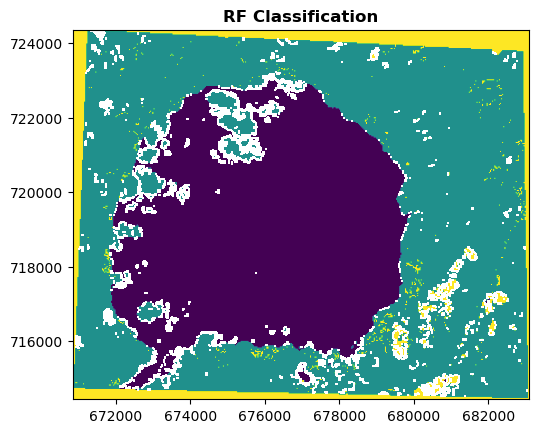

In [13]:
out_meta = src.meta

classified_raster_path = os.path.join(classified_path, "rf.tif")

with rio.open(classified_raster_path, 'w',  **out_meta) as dst:
    dst.write(rf_predictions, 1)

with rio.open(classified_raster_path) as dataset:
    r_show(dataset, title="RF Classification")